In [53]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
np.random.seed(0)

import os
import wget
from pathlib import Path
import shutil
import gzip

from matplotlib import pyplot as plt
%matplotlib inline

# Download ForestCoverType dataset

In [54]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"
dataset_name = 'forest-cover-type'
tmp_out = Path('./data/'+dataset_name+'.gz')
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [55]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, tmp_out.as_posix())
    with gzip.open(tmp_out, 'rb') as f_in:
        with open(out, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)


File already exists.


# Load data and split
Same split as in original paper

In [56]:
target = "Covertype"

bool_columns = [
    "Wilderness_Area1", "Wilderness_Area2", "Wilderness_Area3",
    "Wilderness_Area4", "Soil_Type1", "Soil_Type2", "Soil_Type3", "Soil_Type4",
    "Soil_Type5", "Soil_Type6", "Soil_Type7", "Soil_Type8", "Soil_Type9",
    "Soil_Type10", "Soil_Type11", "Soil_Type12", "Soil_Type13", "Soil_Type14",
    "Soil_Type15", "Soil_Type16", "Soil_Type17", "Soil_Type18", "Soil_Type19",
    "Soil_Type20", "Soil_Type21", "Soil_Type22", "Soil_Type23", "Soil_Type24",
    "Soil_Type25", "Soil_Type26", "Soil_Type27", "Soil_Type28", "Soil_Type29",
    "Soil_Type30", "Soil_Type31", "Soil_Type32", "Soil_Type33", "Soil_Type34",
    "Soil_Type35", "Soil_Type36", "Soil_Type37", "Soil_Type38", "Soil_Type39",
    "Soil_Type40"
]

int_columns = [
    "Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]

feature_columns = (
    int_columns + bool_columns + [target])


In [57]:
train = pd.read_csv(out, header=None, names=feature_columns)

n_total = len(train)

# Train, val and test split follows
# Rory Mitchell, Andrey Adinets, Thejaswi Rao, and Eibe Frank.
# Xgboost: Scalable GPU accelerated learning. arXiv:1806.11248, 2018.

train_val_indices, test_indices = train_test_split(
    range(n_total), test_size=0.2, random_state=0)
train_indices, valid_indices = train_test_split(
    train_val_indices, test_size=0.2 / 0.6, random_state=0)


# Simple preprocessing

Label encode categorical features and fill empty cells.

In [58]:
categorical_columns = []
categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in train.columns[train.dtypes == 'float64']:
    train.fillna(train.loc[train_indices, col].mean(), inplace=True)

# Define categorical features for categorical embeddings

In [59]:
# This is a generic pipeline but actually no categorical features are available for this dataset

unused_feat = []

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]


# Network parameters

In [60]:
clf = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=1,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

/home/yoeriapts/workspace/tabnet/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


# Training

In [61]:
if os.getenv("CI", False):
# Take only a subsample to run CI
    X_train = train[features].values[train_indices][:1000,:]
    y_train = train[target].values[train_indices][:1000]
else:
    X_train = train[features].values[train_indices]
    y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [65]:
#X_valid

In [10]:
max_epochs = 100 if not os.getenv("CI", False) else 2

In [11]:
from pytorch_tabnet.augmentations import ClassificationSMOTE
aug = ClassificationSMOTE(p=0.2)

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs, patience=100,
    batch_size=16384, virtual_batch_size=256,
    augmentations=aug
) 

epoch 0  | loss: 1.32746 | train_accuracy: 0.43832 | valid_accuracy: 0.43738 |  0:00:05s
epoch 1  | loss: 0.85895 | train_accuracy: 0.12408 | valid_accuracy: 0.12358 |  0:00:09s
epoch 2  | loss: 0.7615  | train_accuracy: 0.12087 | valid_accuracy: 0.12095 |  0:00:14s
epoch 3  | loss: 0.73034 | train_accuracy: 0.06845 | valid_accuracy: 0.06869 |  0:00:18s
epoch 4  | loss: 0.71299 | train_accuracy: 0.13499 | valid_accuracy: 0.1353  |  0:00:23s
epoch 5  | loss: 0.69701 | train_accuracy: 0.06534 | valid_accuracy: 0.06526 |  0:00:27s
epoch 6  | loss: 0.6878  | train_accuracy: 0.04551 | valid_accuracy: 0.04605 |  0:00:32s
epoch 7  | loss: 0.6767  | train_accuracy: 0.05311 | valid_accuracy: 0.05395 |  0:00:36s
epoch 8  | loss: 0.66672 | train_accuracy: 0.11718 | valid_accuracy: 0.11694 |  0:00:41s
epoch 9  | loss: 0.65553 | train_accuracy: 0.25431 | valid_accuracy: 0.25412 |  0:00:45s
epoch 10 | loss: 0.64651 | train_accuracy: 0.28166 | valid_accuracy: 0.28081 |  0:00:50s
epoch 11 | loss: 0.64

/home/yoeriapts/workspace/tabnet/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


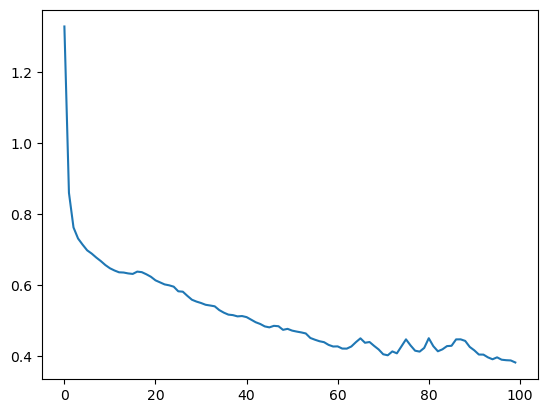

In [12]:
# plot losses
plt.plot(clf.history['loss'])

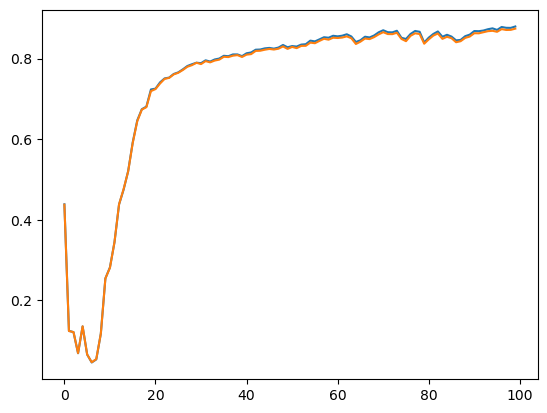

In [13]:
# plot accuracy
plt.plot(clf.history['train_accuracy'])
plt.plot(clf.history['valid_accuracy'])

### Predictions


In [14]:
# To get final results you may need to use a mapping for classes 
# as you are allowed to use targets like ["yes", "no", "maybe", "I don't know"]

preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}

preds = clf.predict_proba(X_test)

y_pred = np.vectorize(preds_mapper.get)(np.argmax(preds, axis=1))

test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_acc}")

BEST VALID SCORE FOR forest-cover-type : 0.8745877356603007
FINAL TEST SCORE FOR forest-cover-type : 0.8770255501148851


In [15]:
# or you can simply use the predict method
y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_acc}")

FINAL TEST SCORE FOR forest-cover-type : 0.8770255501148851


# Save and load Model

In [16]:
# save state dict
saved_filename = clf.save_model('test_model')

Successfully saved model at test_model.zip


In [17]:
# define new model and load save parameters
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filename)

/home/yoeriapts/workspace/tabnet/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [18]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_y_pred = np.vectorize(preds_mapper.get)(np.argmax(loaded_preds, axis=1))

loaded_test_acc = accuracy_score(y_pred=loaded_y_pred, y_true=y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_acc}")

FINAL TEST SCORE FOR forest-cover-type : 0.8770255501148851


In [19]:
assert(test_acc == loaded_test_acc)

# Global explainability : feat importance summing to 1

In [20]:
clf.feature_importances_

array([1.72880831e-01, 1.82164748e-02, 4.85733121e-04, 1.10793879e-02,
       1.95500509e-02, 7.79269180e-02, 1.00785771e-02, 3.13781764e-02,
       4.61790591e-03, 9.96770160e-02, 6.41750150e-02, 8.09256768e-03,
       2.13701825e-02, 5.24763602e-02, 1.33063768e-02, 1.52875264e-02,
       6.91364740e-03, 4.14096422e-03, 9.33264256e-05, 2.66056176e-04,
       5.73183549e-06, 1.65271821e-02, 8.70154708e-04, 1.89734067e-04,
       0.00000000e+00, 3.67260191e-02, 8.12090125e-06, 5.79571136e-04,
       1.20799859e-05, 1.49322989e-08, 7.96923855e-03, 2.04596448e-03,
       4.69874039e-03, 2.04906299e-03, 5.92377440e-03, 5.41454488e-02,
       1.95983918e-02, 1.07847592e-02, 6.87803217e-08, 2.75636166e-04,
       5.07759401e-03, 4.63382083e-06, 2.44031873e-04, 3.34173581e-02,
       3.12899690e-02, 1.32822184e-02, 1.60924537e-02, 4.75301128e-03,
       0.00000000e+00, 2.46453511e-03, 7.43005601e-06, 3.25318157e-02,
       6.64033774e-02, 8.78350459e-06])

# Local explainability and masks

In [21]:
explain_matrix, masks = clf.explain(X_test)

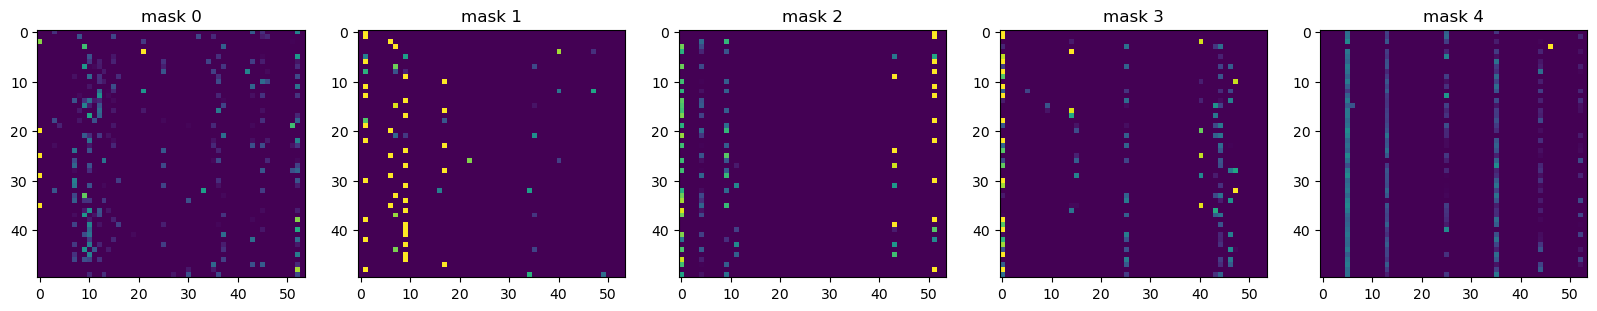

In [22]:
fig, axs = plt.subplots(1, 5, figsize=(20,20))

for i in range(5):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

# XGB

In [68]:
#X_train
#y_train

array([2, 1, 1, ..., 2, 7, 2])

In [44]:
# The number of trees (or rounds) in an XGBoost model is specified to the XGBClassifier or XGBRegressor class 
# in the n_estimators argument. The default in the XGBoost library is 100.
n_estimators = 1000 if not os.getenv("CI", False) else 20

In [45]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier(max_depth=8,
    learning_rate=0.1,
    n_estimators=n_estimators,
    verbosity=0,
    silent=None,
    objective="multi:softmax",
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)


In [46]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_valid, return_counts=True))

(array([1, 2, 3, 4, 5, 6, 7]), array([112996, 151174,  18985,   1481,   5108,   9173,  10955]))
(array([1, 2, 3, 4, 5, 6, 7]), array([56632, 75278,  9675,   697,  2499,  4692,  5464]))


In [47]:
clf_xgb.fit(X_train, y_train - 1,
            eval_set=[(X_valid, y_valid - 1)],
            early_stopping_rounds=40,
            verbose=10)

/opt/anaconda/envs/juplab_hk_torch/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:1.74261
[10]	validation_0-mlogloss:0.90293
[20]	validation_0-mlogloss:0.63492
[30]	validation_0-mlogloss:0.52119
[40]	validation_0-mlogloss:0.46309
[50]	validation_0-mlogloss:0.42350
[60]	validation_0-mlogloss:0.39951
[70]	validation_0-mlogloss:0.38313
[80]	validation_0-mlogloss:0.37007
[90]	validation_0-mlogloss:0.35967
[99]	validation_0-mlogloss:0.34997


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
              max_depth=8, max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=-1,
              nthread=None, num_parallel_tree=None, objective='multi:softmax', ...)

In [48]:
preds_valid = np.array(clf_xgb.predict_proba(X_valid, ))
valid_acc = accuracy_score(y_pred=np.argmax(preds_valid, axis=1) + 1, y_true=y_valid)
print(valid_acc)

0.8634799950947805


In [49]:
preds_test = np.array(clf_xgb.predict_proba(X_test))
test_acc = accuracy_score(y_pred=np.argmax(preds_test, axis=1) + 1, y_true=y_test)
print(test_acc)

0.8632049086512397


In [51]:
print(f"FINAL TEST SCORE FOR Tabnet on {dataset_name} : {loaded_test_acc}")


FINAL TEST SCORE FOR Tabnet on forest-cover-type : 0.8770255501148851
